# Hello! Welcome to this notebook!
## Today we are going to supose an Indian bank contacted us, and as Data Scientists, we need to analyze their data, group/segmentate their clients depending on their spending habits and obtain insights with conclussions.
## Hope you enjoy it!
## Let's start!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from time import time
from sklearn.preprocessing import scale
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn import decomposition as dc
from pca import pca
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
execfile(r'C:\Users\adrag\Desktop\Master Data Science UCM\Módulo minería de datos 1\NuestrasFunciones.py')

# Step 1 - Reading data, check nulls, check dtypes

In [3]:
credit = pd.read_csv("Credit card transactions - India - Simple.csv")

In [4]:
credit

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574
...,...,...,...,...,...,...,...
26047,26047,"Kolkata, India",22-Jun-14,Silver,Travel,F,128191
26048,26048,"Pune, India",3-Aug-14,Signature,Travel,M,246316
26049,26049,"Hyderabad, India",16-Jan-15,Silver,Travel,M,265019
26050,26050,"Kanpur, India",14-Sep-14,Silver,Travel,M,88174


In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      26052 non-null  int64 
 1   City       26052 non-null  object
 2   Date       26052 non-null  object
 3   Card Type  26052 non-null  object
 4   Exp Type   26052 non-null  object
 5   Gender     26052 non-null  object
 6   Amount     26052 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


### At first sight it looks obvious that the column Date has to be dtype Datetime.
### Appart from that Index can be eliminated
### The rest of the columns will be analyzed in the exploratory data analysis
### No nulls in this dataset, which is great

In [6]:
credit.Date = pd.to_datetime(credit.Date)

In [7]:
credit.drop("index",axis = 1,inplace = True)

In [8]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   City       26052 non-null  object        
 1   Date       26052 non-null  datetime64[ns]
 2   Card Type  26052 non-null  object        
 3   Exp Type   26052 non-null  object        
 4   Gender     26052 non-null  object        
 5   Amount     26052 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.2+ MB


# Step 2 - Exploratory Data Analysis (EDA)

## Let's start with the city variable

In [9]:
credit.City

0                 Delhi, India
1        Greater Mumbai, India
2             Bengaluru, India
3        Greater Mumbai, India
4             Bengaluru, India
                 ...          
26047           Kolkata, India
26048              Pune, India
26049         Hyderabad, India
26050            Kanpur, India
26051         Hyderabad, India
Name: City, Length: 26052, dtype: object

### We are going to check if all cities are from India, if not, it would be an outlier or wrong taken data, as this dataset is suposed to be all from India

In [10]:
#I will create a new variable named Country that will have the country of each observation
credit["Country"] = credit.City.apply(lambda x: x.split(",")[1])

In [11]:
credit.Country.value_counts()

Country
 India    26052
Name: count, dtype: int64

### Now we are sure all cities are from India, let's drop the new variable and transform the variable City, leaving only the city

In [12]:
credit.drop("Country",axis = 1,inplace = True)

In [13]:
credit["City"] = credit.City.apply(lambda x: x.split(",")[0])

In [14]:
credit.City

0                 Delhi
1        Greater Mumbai
2             Bengaluru
3        Greater Mumbai
4             Bengaluru
              ...      
26047           Kolkata
26048              Pune
26049         Hyderabad
26050            Kanpur
26051         Hyderabad
Name: City, Length: 26052, dtype: object

### Let's check the distribution of observations by city

In [15]:
credit.City.value_counts()

City
Bengaluru          3552
Greater Mumbai     3493
Ahmedabad          3491
Delhi              3482
Hyderabad           784
                   ... 
Rayagada              1
Varanasi              1
Hugli-Chinsurah       1
Alirajpur             1
Fazilka               1
Name: count, Length: 986, dtype: int64

In [16]:
credit["City"].value_counts()[credit["City"].value_counts() <740]

City
Ramnagar            19
Kalyan-Dombivali    19
Vijayapura          15
Udaipur             15
Pratapgarh          14
                    ..
Rayagada             1
Varanasi             1
Hugli-Chinsurah      1
Alirajpur            1
Fazilka              1
Name: count, Length: 974, dtype: int64

In [17]:
credit["City"].value_counts()[credit["City"].value_counts() >740]

City
Bengaluru         3552
Greater Mumbai    3493
Ahmedabad         3491
Delhi             3482
Hyderabad          784
Chennai            774
Kolkata            773
Kanpur             764
Lucknow            759
Jaipur             752
Surat              749
Pune               747
Name: count, dtype: int64

### Here there is a clear difference between cities, after looking for information about them, i soon realised the ones with over 700 appareances are big cities, with more than 4 million people each.
### The rest are smaller towns or cities, with less than 1 million people living each, many of whom has less than 50k habitants.
### It would be interesting to discover if the consumer habits of indian people could change if the transactions are done in a big city or in a small city.
### Let's create another variable "Big city" with a value of 1 or 0

In [18]:
credit["Big_city"] = credit["City"].replace(["Bengaluru","Greater Mumbai","Ahmedabad","Delhi","Hyderabad","Chennai","Kolkata","Kanpur","Lucknow","Jaipur","Surat","Pune"],1)

In [19]:
credit["Big_city"] = credit["Big_city"].apply(lambda x: 1 if x == 1 else 0)

In [20]:
credit.Big_city.value_counts()

Big_city
1    20120
0     5932
Name: count, dtype: int64

### It looks like even if we joined all small cities they still have less observations than the ones of big cities

### We are gonna end up deleting the variable City as we created the variable Big_city, which is more meaningful

In [21]:
credit.drop("City",axis = 1,inplace = True)

## Lets continue with Date variable

In [22]:
credit.Date

0       2014-10-29
1       2014-08-22
2       2014-08-27
3       2014-04-12
4       2015-05-05
           ...    
26047   2014-06-22
26048   2014-08-03
26049   2015-01-16
26050   2014-09-14
26051   2013-10-19
Name: Date, Length: 26052, dtype: datetime64[ns]

### Lets first check in number of transactions for each day

In [23]:
credit.Date.value_counts()

Date
2014-09-20    65
2013-12-21    61
2014-11-15    61
2014-08-11    61
2015-02-20    60
              ..
2014-08-29    27
2014-05-09    26
2014-02-28    25
2014-07-30    24
2015-04-11    23
Name: count, Length: 600, dtype: int64

<Axes: xlabel='Date'>

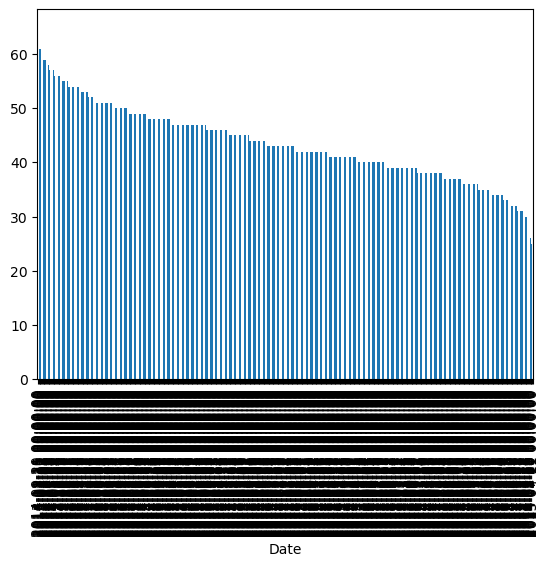

In [24]:
credit.Date.value_counts().plot(kind = "bar")

### Okay, we cant see nothing in this plot, but it looks kinda flat, lets check the minimum and maximum value

In [25]:
credit.Date.value_counts().min()

23

In [26]:
credit.Date.value_counts().max()

65

### Not a lot of difference in number of transactions, lets check the first top 10 number of transactions and its date

In [27]:
credit.Date.value_counts().sort_values(ascending= False).head(10)

Date
2014-09-20    65
2014-11-15    61
2014-08-11    61
2013-12-21    61
2015-02-20    60
2015-01-12    60
2015-02-07    59
2013-12-13    59
2014-04-03    59
2015-03-18    59
Name: count, dtype: int64

### Im not sure if something really special occurs on those days

### Let's continue with the Card Type

In [28]:
credit["Card Type"].value_counts()

Card Type
Silver       6840
Signature    6447
Platinum     6398
Gold         6367
Name: count, dtype: int64

### For sure this is a category, let's change dtype

In [29]:
credit["Card Type"] = credit["Card Type"].astype("category")

### Appart from that it looks so balanced the use of each one, let's see if there are differences with the amount spent

<Axes: xlabel='Card Type', ylabel='Amount'>

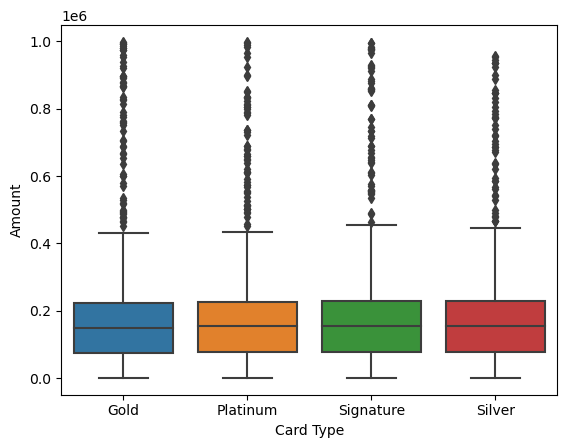

In [30]:
sns.boxplot(x  = credit["Card Type"], y = credit.Amount)

### This is so interesting, appart from lots of outliers there is almost no difference in the use of each type of card, let's compare between men and women

<Axes: xlabel='Card Type', ylabel='Amount'>

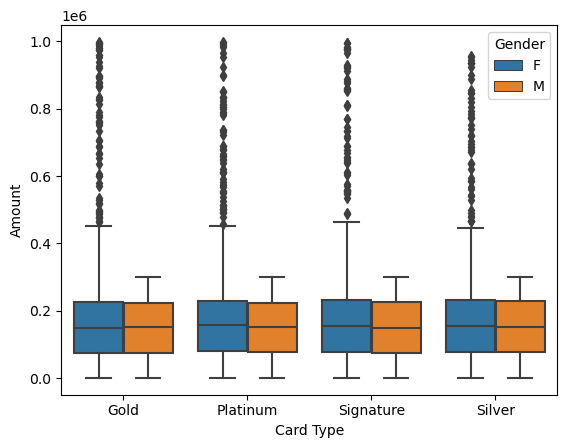

In [31]:
sns.boxplot(x  = credit["Card Type"], y = credit.Amount, hue = credit.Gender)

### Here we just discovered an amazing insight, even if the median and until 75% of the amount spent is more or less the same, some women tend to spend incredible amounts of money, considered outliers by this boxplot

### To finish wiht this card type, lets see if there is any difference about the city they belong to.

<Axes: xlabel='Big_city'>

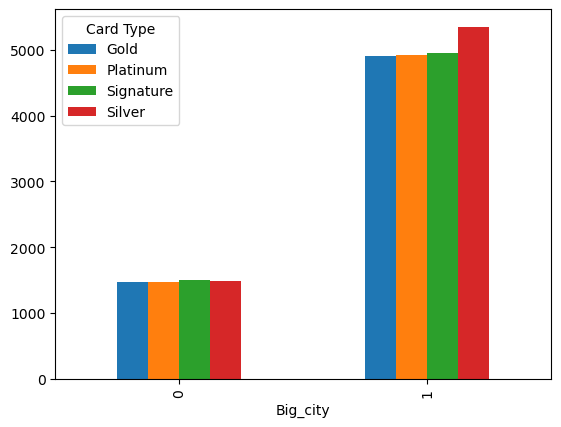

In [32]:
credit.groupby("Big_city")["Card Type"].value_counts().unstack().plot(kind = "bar")

### It is normal that more cards are in the big cities, but it looks like are more or less the same.

## Variable Exp Type

In [33]:
credit["Exp Type"].value_counts()

Exp Type
Food             5463
Fuel             5257
Bills            5078
Entertainment    4762
Grocery          4754
Travel            738
Name: count, dtype: int64

### This is also a category, lets change its dtype

In [34]:
credit["Exp Type"] = credit["Exp Type"].astype("category")

### Let's see how much money they spent on each category

<Axes: xlabel='Exp Type', ylabel='Amount'>

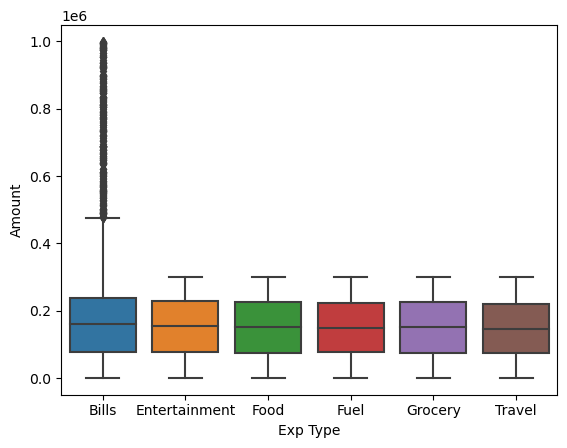

In [35]:
sns.boxplot(x  = credit["Exp Type"], y = credit.Amount)

### Here we have 2 interesting insights, first of all the bills, it has a lot of outliers, meaning the costs are higher. Another interesting insight is Travel, as it only has 738 observations, the amount spent is more or less the same as the others

### Lets see about the card type

<Axes: xlabel='Exp Type'>

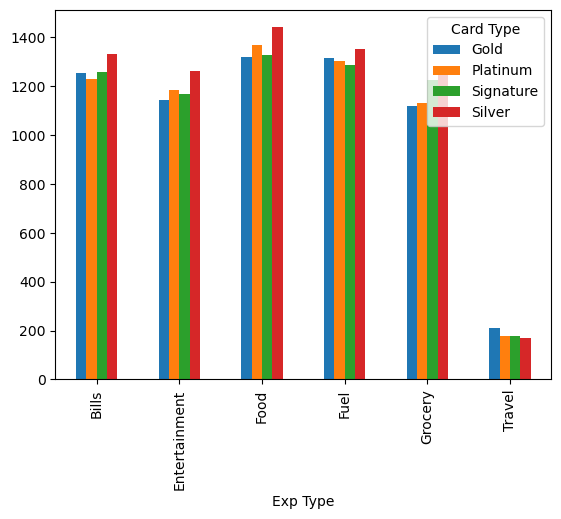

In [36]:
credit.groupby("Exp Type")["Card Type"].value_counts().unstack().plot(kind = "bar")

### More or less the same,it looks in general terms Silver Card is used more in general except Travel

## Variable Gender

In [37]:
credit.Gender.value_counts()

Gender
F    13680
M    12372
Name: count, dtype: int64

### Balanced, let's change the dtype to category

In [38]:
credit.Gender = credit.Gender.astype("category")

### We already checked the money spent and the card type used. We are going to check if differences can appear deppending on the city

<Axes: xlabel='Big_city', ylabel='Amount'>

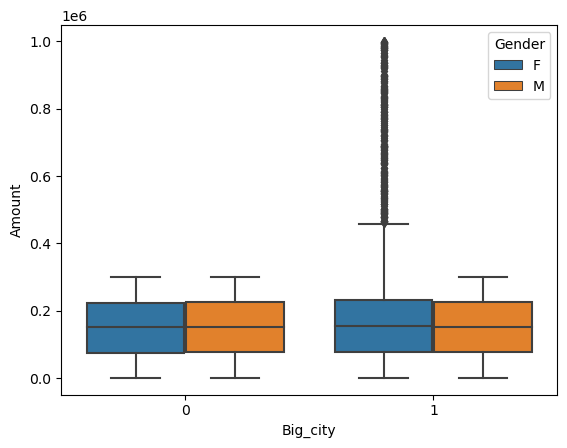

In [39]:
sns.boxplot(x = credit["Big_city"],y = credit.Amount, hue = credit.Gender)

### This is so impressive, here we can take an amazing insight. Women and men tend to pay the same in small cities, but in big cities the females tend to make higher transactions, men tend to pay the same

## Variable Amount

In [40]:
credit.Amount

0         82475
1         32555
2        101738
3        123424
4        171574
          ...  
26047    128191
26048    246316
26049    265019
26050     88174
26051    184410
Name: Amount, Length: 26052, dtype: int64

### Lets check if there are differences in the total amount by men and women

In [41]:
credit.groupby("Gender")["Amount"].sum()

Gender
F    2205311030
M    1869522343
Name: Amount, dtype: int64

### It looks like women in general has a higher amount spent, but the difference is not really big

### Now we are going to check amount over the time

In [42]:
credit.groupby("Date")["Amount"].sum()

Date
2013-10-04    9738755
2013-10-05    8062632
2013-10-06    6990055
2013-10-07    7822992
2013-10-08    5832533
               ...   
2015-05-22    6613863
2015-05-23    6393798
2015-05-24    7171912
2015-05-25    5176669
2015-05-26    7591837
Name: Amount, Length: 600, dtype: int64

<Axes: xlabel='Date'>

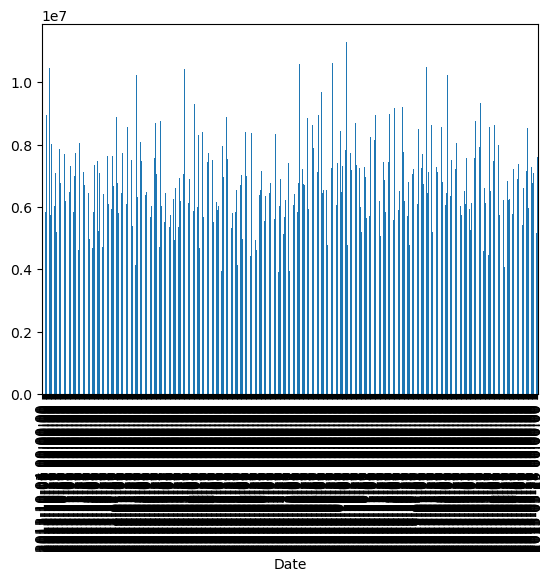

In [43]:
credit.groupby("Date")["Amount"].sum().plot(kind = "bar")

### This graphic is again difficult to check, altough we can imagine that is kinda flat, except for some values that exceed 10M

### Lets check the first 10 values

In [44]:
credit.groupby("Date")["Amount"].sum().sort_values(ascending = False).head(10)

Date
2014-10-07    11282456
2014-09-20    10627971
2014-08-11    10581084
2015-01-12    10498169
2013-10-13    10439795
2014-03-25    10433999
2015-02-06    10233778
2014-01-26    10226607
2015-01-16    10111932
2015-04-28     9981496
Name: Amount, dtype: int64

### Lets now plot it over the time to check any kind of trend or seasoning

<Axes: xlabel='Date', ylabel='Amount'>

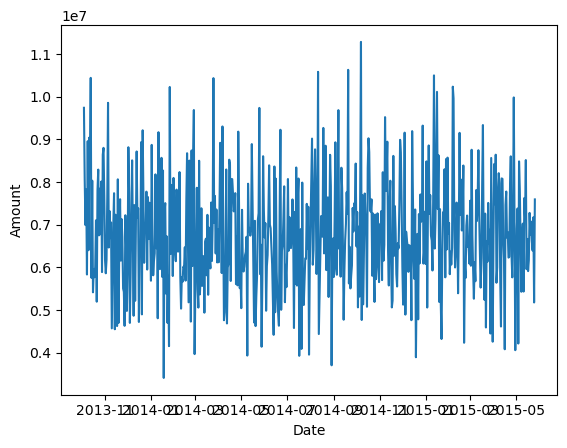

In [45]:
sns.lineplot(credit.groupby("Date")["Amount"].sum())

### So confusing, at least something is clear, it doesnt look to have any trend up or down. Lets group it by month and check again

In [46]:
#Creation of a new variable were we are going to select only the month
credit["Date_month"] = credit.Date.astype("object")

In [47]:
credit["Date_month"] = credit["Date_month"].apply(lambda x: str(x)[:7])

In [48]:
credit["Date_month"] = pd.to_datetime(credit["Date_month"])

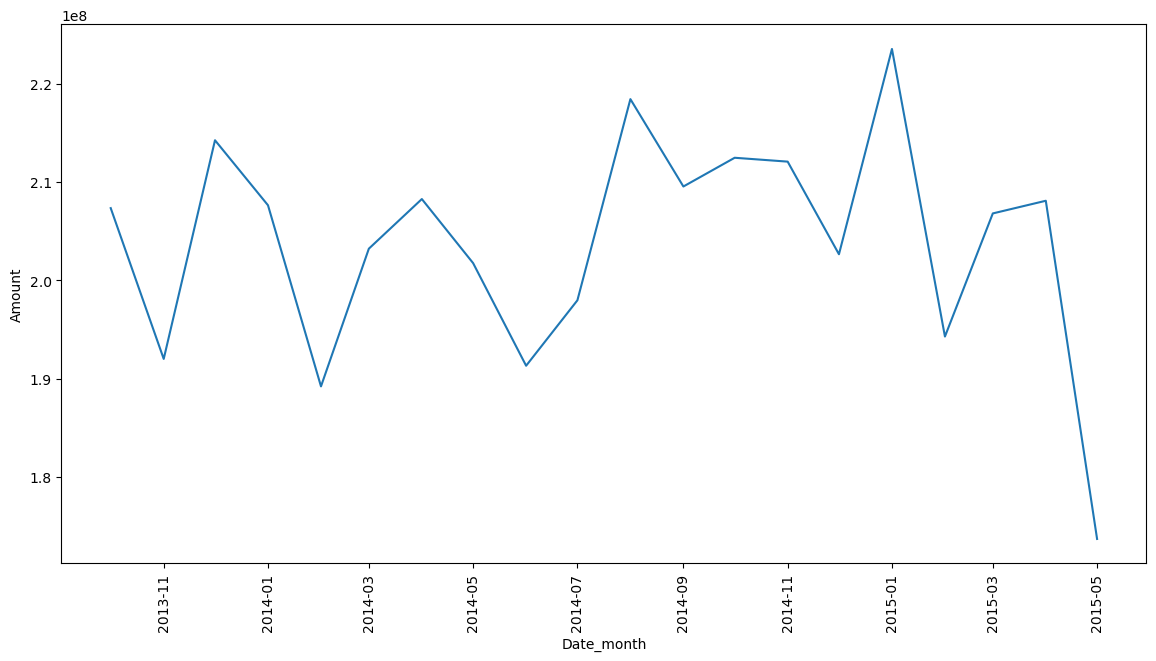

In [49]:
plt.figure(figsize=(14, 7))
sns.lineplot(credit.groupby("Date_month")["Amount"].sum())
plt.xticks(rotation=90)
plt.show()

### Difficult to bring any insights except for that drop in amount spent in May 2015

### Lets check if there is any trend were people did more number of transactions, forgetting about the amount of  money spent

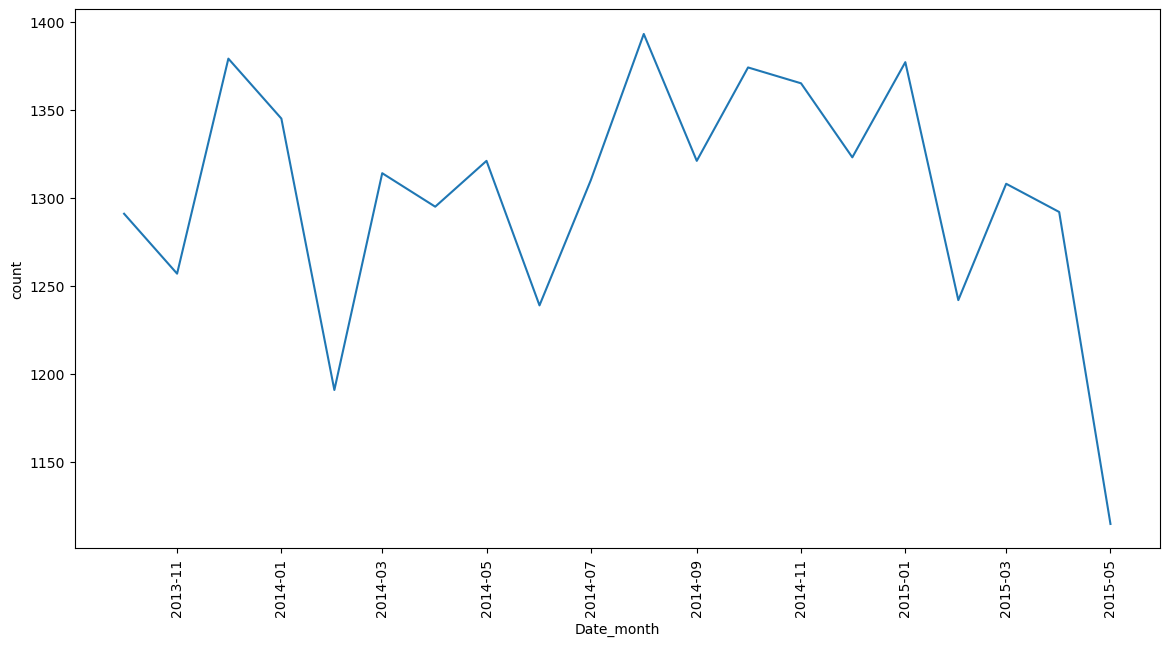

In [50]:
plt.figure(figsize=(14, 7))
sns.lineplot(credit.Date_month.value_counts())
plt.xticks(rotation=90)
plt.show()

### I cant see any kind of trend or seasoning in any of both plots, it can be normal as we are taking just one and half year

### Variable Date cant give us any kind of information so we wont use it on the models

In [51]:
credit.drop(["Date","Date_month"],axis = 1,inplace = True)

# Conclussion of the EDA:
## City: Changed to Big city (1) and Small city (0), more transactions done in Big cities than small cities.
## Card type: No differences in the amount spent or number of transactions
## Exp type: No differences in the amount spent or number of transactions, except for travel that has lower number of transactions
## Gender: Balanced number of transactions for men and women, the most important insight is that woman tend to buy more expensive things when they are in big cities
## Amount: No trends or seasonality in this time period. Women paid total amount higher than men, but not a huge difference

In [52]:
#This is the final dataset we will use for customer segmentation
credit

,Card Type,Exp Type,Gender,Amount,Big_city
0,Gold,Bills,F,82475,1
1,Platinum,Bills,F,32555,1
2,Silver,Bills,F,101738,1
3,Signature,Bills,F,123424,1
4,Gold,Bills,F,171574,1
...,...,...,...,...,...
26047,Silver,Travel,F,128191,1
26048,Signature,Travel,M,246316,1
26049,Silver,Travel,M,265019,1
26050,Silver,Travel,M,88174,1


# Step 3 - Scale data

### We are going to need to make dummies of the categories, as we are talking about distances in space, we will need to scale data

In [53]:
credit_dummy = pd.get_dummies(credit,drop_first = True)

In [54]:
credit_dummy = credit_dummy.replace([False,True],[0,1])

In [55]:
credit_dummy

,Amount,Big_city,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Exp Type_Entertainment,Exp Type_Food,Exp Type_Fuel,Exp Type_Grocery,Exp Type_Travel,Gender_M
0,82475,1,0,0,0,0,0,0,0,0,0
1,32555,1,1,0,0,0,0,0,0,0,0
2,101738,1,0,0,1,0,0,0,0,0,0
3,123424,1,0,1,0,0,0,0,0,0,0
4,171574,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
26047,128191,1,0,0,1,0,0,0,0,1,0
26048,246316,1,0,1,0,0,0,0,0,1,1
26049,265019,1,0,0,1,0,0,0,0,1,1
26050,88174,1,0,0,1,0,0,0,0,1,1


### We have to keep in mind that we drop the first column of each variable, that means:
#### All Card Type equal to 0 are Gold cars
#### All Exp Type equal to 0 are Bills
#### Gender M equal to 0 means women

### Lets scale it

In [56]:
credit_dummy_scaled = pd.DataFrame(scale(credit_dummy))

In [57]:
#Take the names of the columns
credit_dummy_scaled.columns = credit_dummy.columns

In [58]:
credit_dummy_scaled

,Amount,Big_city,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Exp Type_Entertainment,Exp Type_Food,Exp Type_Fuel,Exp Type_Grocery,Exp Type_Travel,Gender_M
0,-0.717404,0.542983,-0.570554,-0.573450,-0.596680,-0.472941,-0.515108,-0.502793,-0.472455,-0.170745,-0.950992
1,-1.201776,0.542983,1.752683,-0.573450,-0.596680,-0.472941,-0.515108,-0.502793,-0.472455,-0.170745,-0.950992
2,-0.530495,0.542983,-0.570554,-0.573450,1.675939,-0.472941,-0.515108,-0.502793,-0.472455,-0.170745,-0.950992
3,-0.320077,0.542983,-0.570554,1.743832,-0.596680,-0.472941,-0.515108,-0.502793,-0.472455,-0.170745,-0.950992
4,0.147121,0.542983,-0.570554,-0.573450,-0.596680,-0.472941,-0.515108,-0.502793,-0.472455,-0.170745,-0.950992
...,...,...,...,...,...,...,...,...,...,...,...
26047,-0.273823,0.542983,-0.570554,-0.573450,1.675939,-0.472941,-0.515108,-0.502793,-0.472455,5.856690,-0.950992
26048,0.872340,0.542983,-0.570554,1.743832,-0.596680,-0.472941,-0.515108,-0.502793,-0.472455,5.856690,1.051533
26049,1.053814,0.542983,-0.570554,-0.573450,1.675939,-0.472941,-0.515108,-0.502793,-0.472455,5.856690,1.051533
26050,-0.662106,0.542983,-0.570554,-0.573450,1.675939,-0.472941,-0.515108,-0.502793,-0.472455,5.856690,1.051533


# Step 4 - Plot dendograms

### In this step we are going to plot dendograms using different linkages: "ward", "average", "complete", "single"
### This linkages uses different ways to find similarities between data

ward :	45.94s


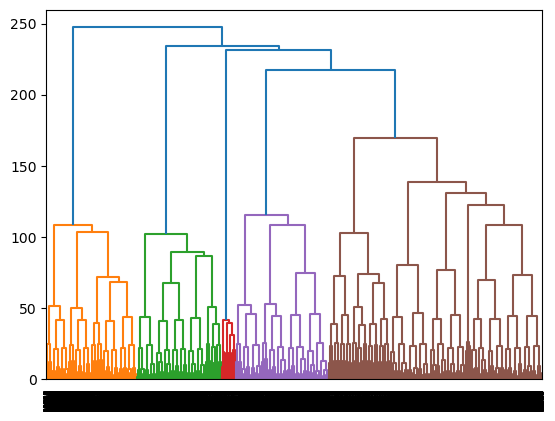

average :	40.18s


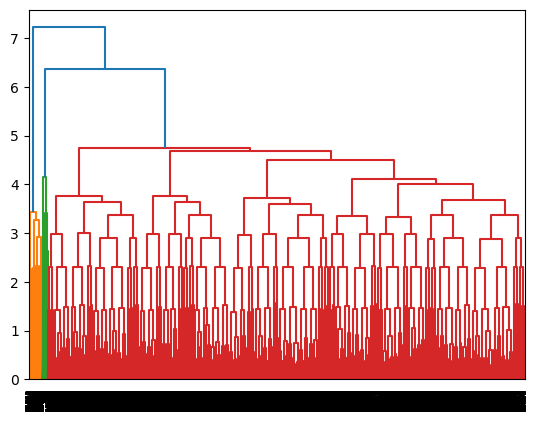

complete :	40.44s


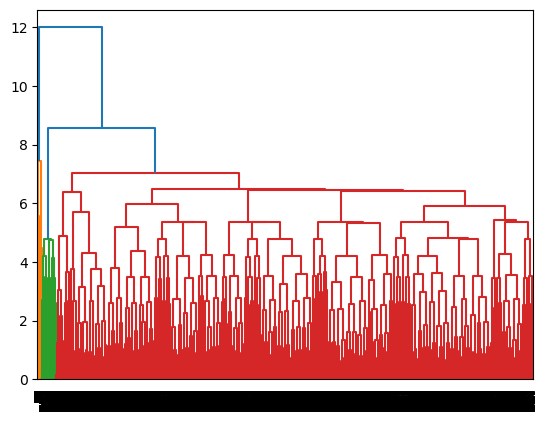

single :	7.58s


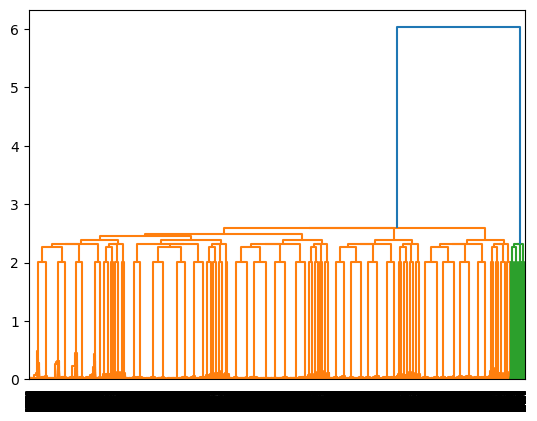

In [70]:
#for linkage in ("ward", "average", "complete", "single"):
#    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
#                            distance_threshold = 0)
#    t0 = time()
#    clustering.fit(credit_dummy_scaled)
#    print("%s :\t%.2fs" % (linkage, time() - t0))
    
#    plt.clf()
#    plot_dendogram(clustering)

### Judging the plots it looks like between 5,6 or 7 clusters could be a great idea

### Lets now plot different plots for the variance and silhouette

In [95]:
#scree_plot_kmeans(credit_dummy,10)
#plt.show()

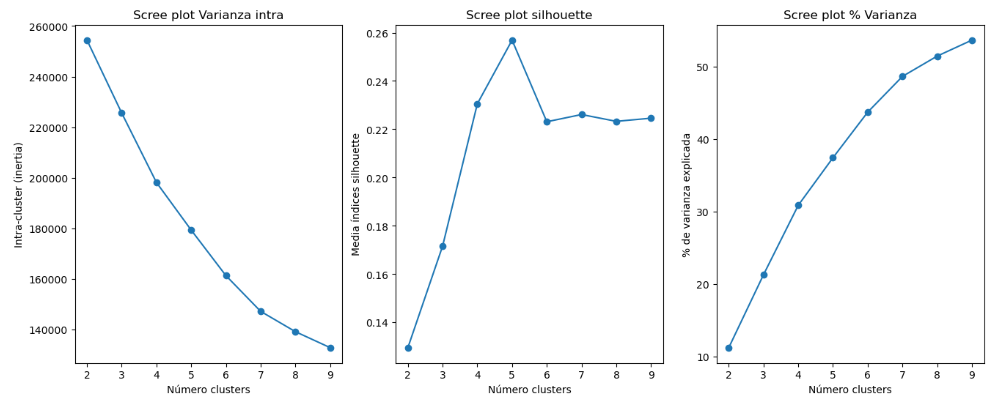

### It is not clear but it looks like it makes an elbow in the variance intra-cluster (left plot) with 7 clusters, also another elbow appears in the explained variance (right plot) with 7 clusters, explaining more or less 50% of variance, which is too low. Lets take 7 clusters even if so many clusters makes harder to explain the model

# Step 5 - Model

### After selecting the number of clusters thanks to the plots and dendograms, we are going to train a KMeans model

In [82]:
modelo_kmeans = KMeans(n_clusters=5, n_init=25, random_state=123)
modelo_kmeans.fit(X=credit_dummy_scaled)

KMeans(n_clusters=5, n_init=25, random_state=123)

In [83]:
# This variable will keep the labels, we will use it later for plotting
cluster=modelo_kmeans.labels_

In [84]:
cluster

array([1, 1, 1, ..., 3, 3, 1])

In [85]:
### Lets check the centroids
print(modelo_kmeans.cluster_centers_)

[[-3.74797012e-02 -6.24458410e-02  8.54779944e-03 -4.10510872e-03
   5.59718973e-03  2.11442914e+00 -5.15107619e-01 -5.02793351e-01
  -4.72454704e-01 -1.70744921e-01  4.90091123e-02]
 [ 7.64588024e-02 -6.40369027e-04  2.48624304e-03 -4.51661857e-03
   1.60432391e-03 -4.72940891e-01  7.57976878e-01 -5.02793351e-01
  -4.72454704e-01 -1.70744921e-01 -6.39992314e-02]
 [-5.17855999e-02 -3.98889212e-02 -1.83330764e-02  2.31746480e-02
   1.56935278e-02 -4.72940891e-01 -5.15107619e-01 -5.02793351e-01
   2.11660502e+00 -1.70744921e-01  2.87879683e-02]
 [-8.12012465e-02  5.42983438e-01 -7.05875096e-03 -1.13991247e-02
  -7.93361084e-02 -4.72940891e-01 -5.15107619e-01 -5.02793351e-01
  -4.72454704e-01  5.85668959e+00  2.31361857e-02]
 [-6.11296627e-02  1.76959062e-02  4.84167672e-03 -6.58198944e-03
  -1.13414455e-02 -4.72940891e-01 -5.15107619e-01  1.98888867e+00
  -4.72454704e-01 -1.70744921e-01  5.46513218e-02]]


### So hard to identify anything, we have to remember that we are working with 11 dimensions.
### We will need to make a PCA in 2 dimensions to see if we can plot, identify or explain the model better

# Step 6 - PCA

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,Amount,Big_city,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Exp Type_Entertainment,Exp Type_Food,Exp Type_Fuel,Exp Type_Grocery,Exp Type_Travel,Gender_M
PC1,0.009405,0.051251,-0.419934,-0.392581,0.803647,-0.016659,0.052423,-0.062912,0.027697,-0.015774,-0.113899
PC2,-0.001362,-0.015818,-0.686606,0.705863,-0.018715,-0.022425,-0.083582,-0.034362,0.143452,-0.003891,-0.021553


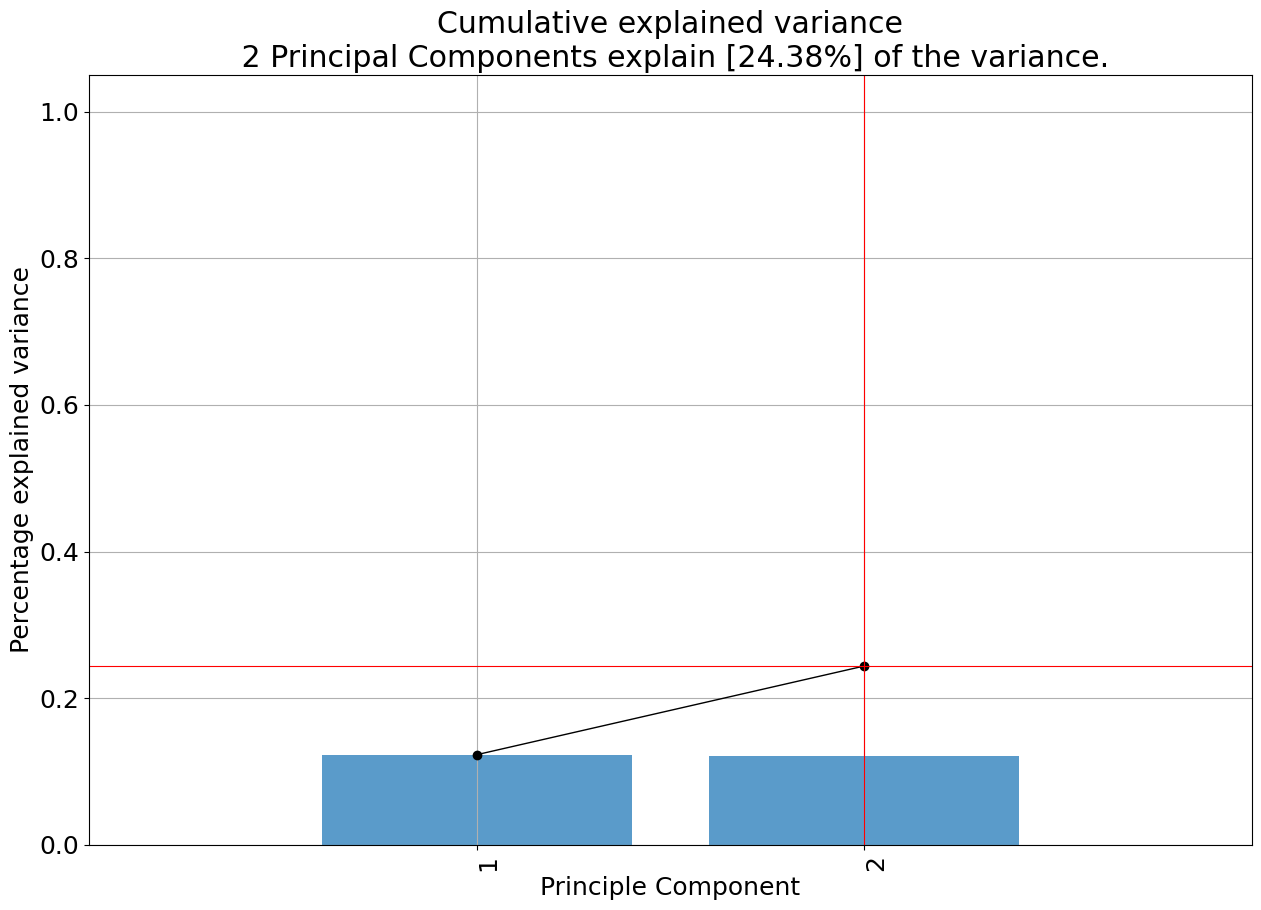

In [86]:
# Initialize pca with default parameters
pcaModel = pca(normalize=True,n_components=2)
results = pcaModel.fit_transform(credit_dummy_scaled)
pcaModel.plot()
# Análisis de cargas
pcaModel.results['loadings']

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [24.38%] of the variance'}, xlabel='PC1 (12.2% expl.var)', ylabel='PC2 (12.0% expl.var)'>)

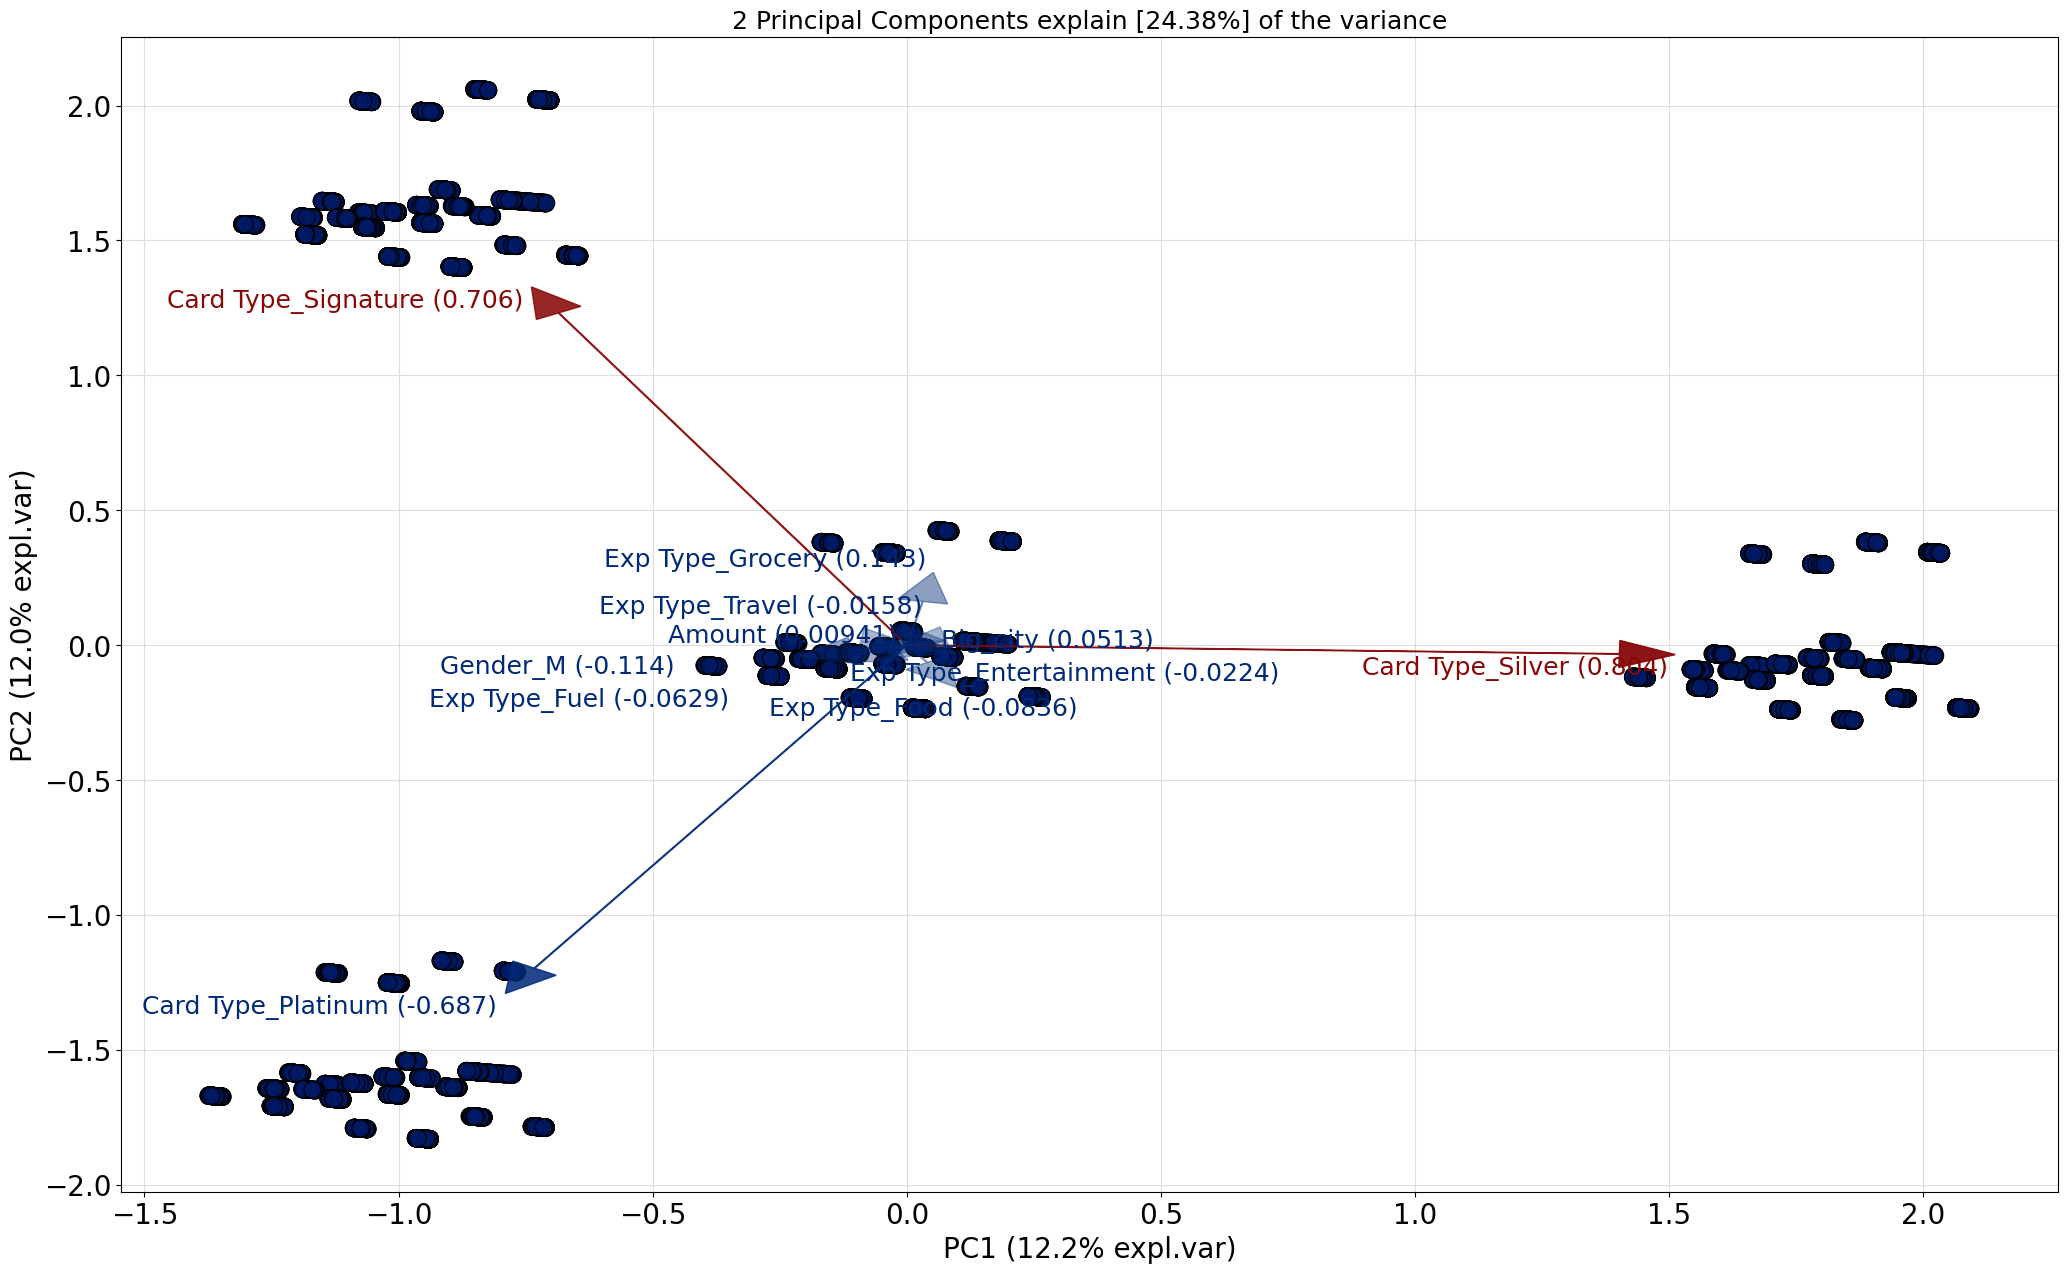

In [87]:
# Biplot
pcaModel.biplot()

### It is so difficult to understand anything with 2 components, its normal, as we only explain 24% of the model. 
### But we just saw something very special, the main differences in this biplot are the Card Type, the rest of variables almost doesnt help with this 2 components.
### As we can remember the variable Exp_Type was so similar in all plots in the previous EDA it didnt make any difference on the amount of money spent or differenciates the Card type or if is Women or men. So i can conclude it is the variable that gives less information to the model, and the one that brings more complexity also, for that reasons Im going to repeat the model withouth this Exp_Type.

# Step 7 - Second model

### We are going now to repeat all previous steps: dummies, scale, dendogram and plots to determine number of clusters

In [59]:
credit_dummy2 = pd.get_dummies(credit.drop("Exp Type", axis = 1),drop_first = True)

In [60]:
credit_dummy2 = credit_dummy2.replace([True,False],[1,0])

In [61]:
credit_dummy_scaled2 = pd.DataFrame(scale(credit_dummy2))

In [62]:
credit_dummy_scaled2.columns = credit_dummy2.columns

In [63]:
credit_dummy_scaled2

,Amount,Big_city,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Gender_M
0,-0.717404,0.542983,-0.570554,-0.573450,-0.596680,-0.950992
1,-1.201776,0.542983,1.752683,-0.573450,-0.596680,-0.950992
2,-0.530495,0.542983,-0.570554,-0.573450,1.675939,-0.950992
3,-0.320077,0.542983,-0.570554,1.743832,-0.596680,-0.950992
4,0.147121,0.542983,-0.570554,-0.573450,-0.596680,-0.950992
...,...,...,...,...,...,...
26047,-0.273823,0.542983,-0.570554,-0.573450,1.675939,-0.950992
26048,0.872340,0.542983,-0.570554,1.743832,-0.596680,1.051533
26049,1.053814,0.542983,-0.570554,-0.573450,1.675939,1.051533
26050,-0.662106,0.542983,-0.570554,-0.573450,1.675939,1.051533


ward :	39.01s


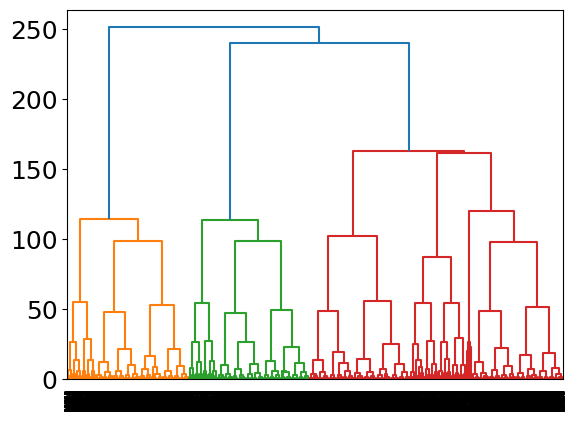

average :	39.83s


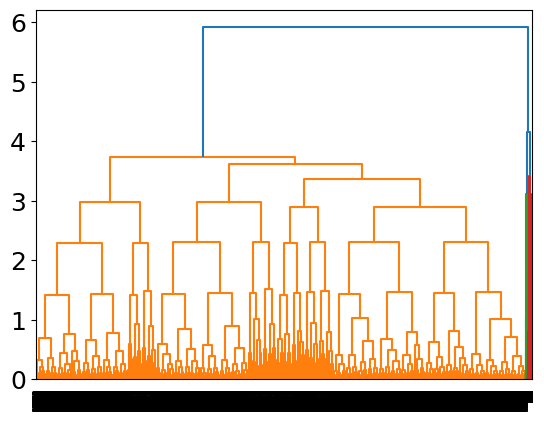

complete :	46.81s


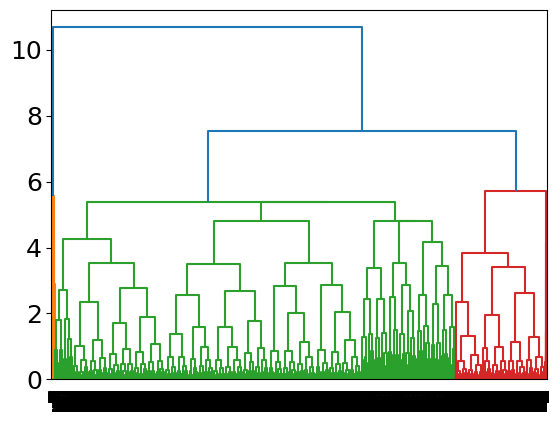

single :	6.68s


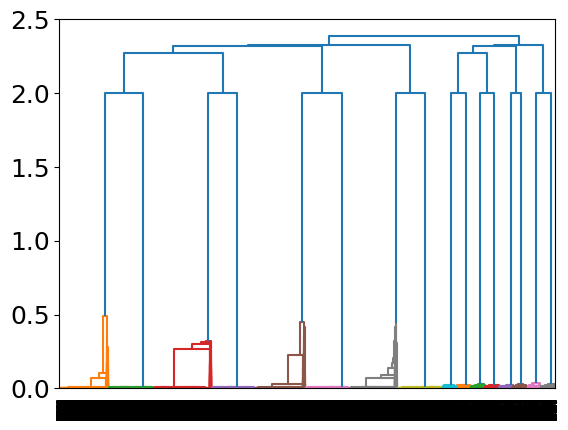

In [111]:
for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(credit_dummy_scaled2)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    plot_dendogram(clustering)

In [96]:
#scree_plot_kmeans(credit_dummy2,10)
#plt.show()

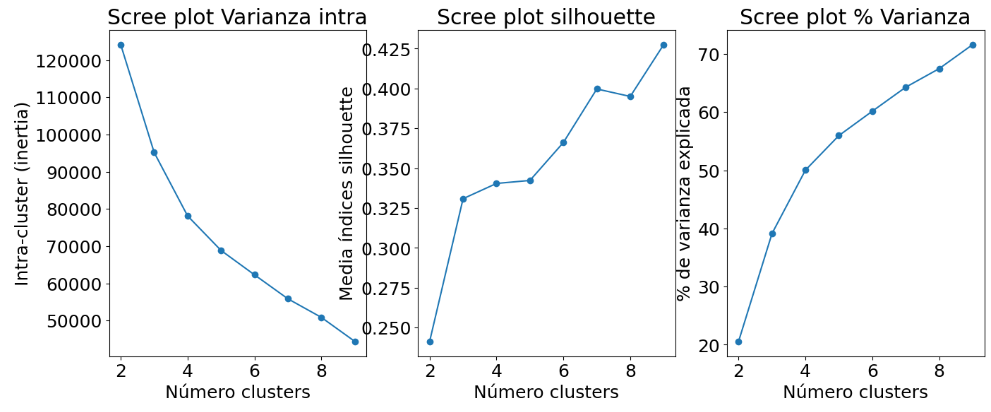

### This time we can see some elbow at 4 or 5 clusters, lets try that

In [ ]:
modelo_kmeans = KMeans(n_clusters=5, n_init=25, random_state=123)
modelo_kmeans.fit(X=credit_dummy_scaled2)

In [ ]:
cluster=modelo_kmeans.labels_

# Step 8 - Second PCA

### Lets start with 3 dimensions in the PCA to see how much information we have

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,Amount,Big_city,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Gender_M
PC1,0.007660,0.056084,-0.410469,-0.406829,0.807312,-0.105108
PC2,0.000407,-0.004693,-0.704554,0.708812,-0.005104,-0.033763
PC3,0.622931,0.506745,0.058299,0.032429,-0.071667,-0.587860


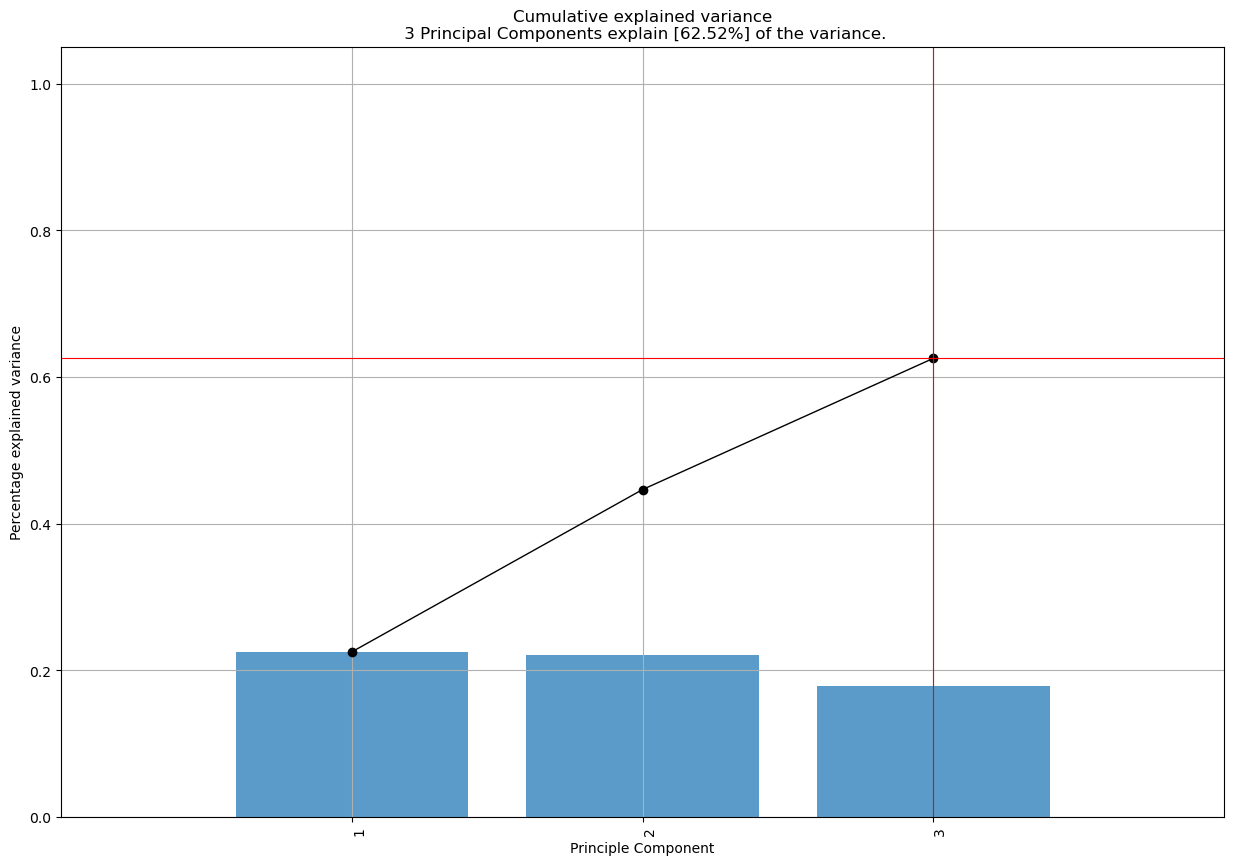

In [64]:
# Initialize pca with default parameters
pcaModel = pca(normalize=True,n_components=3)
results = pcaModel.fit_transform(credit_dummy_scaled2)
pcaModel.plot()
# Análisis de cargas
pcaModel.results['loadings']

### It is way better this time. With two components we have more than 40% of explanation for the model, but adding a third dimension goes up until 62%, which, in general terms, can not be bad. Let's check the plots

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes3D: title={'center': '3 Principal Components explain [62.52%] of the variance'}, xlabel='PC1 (22.5% expl.var)', ylabel='PC2 (22.1% expl.var)', zlabel='PC3 (17.8% expl.var)'>)

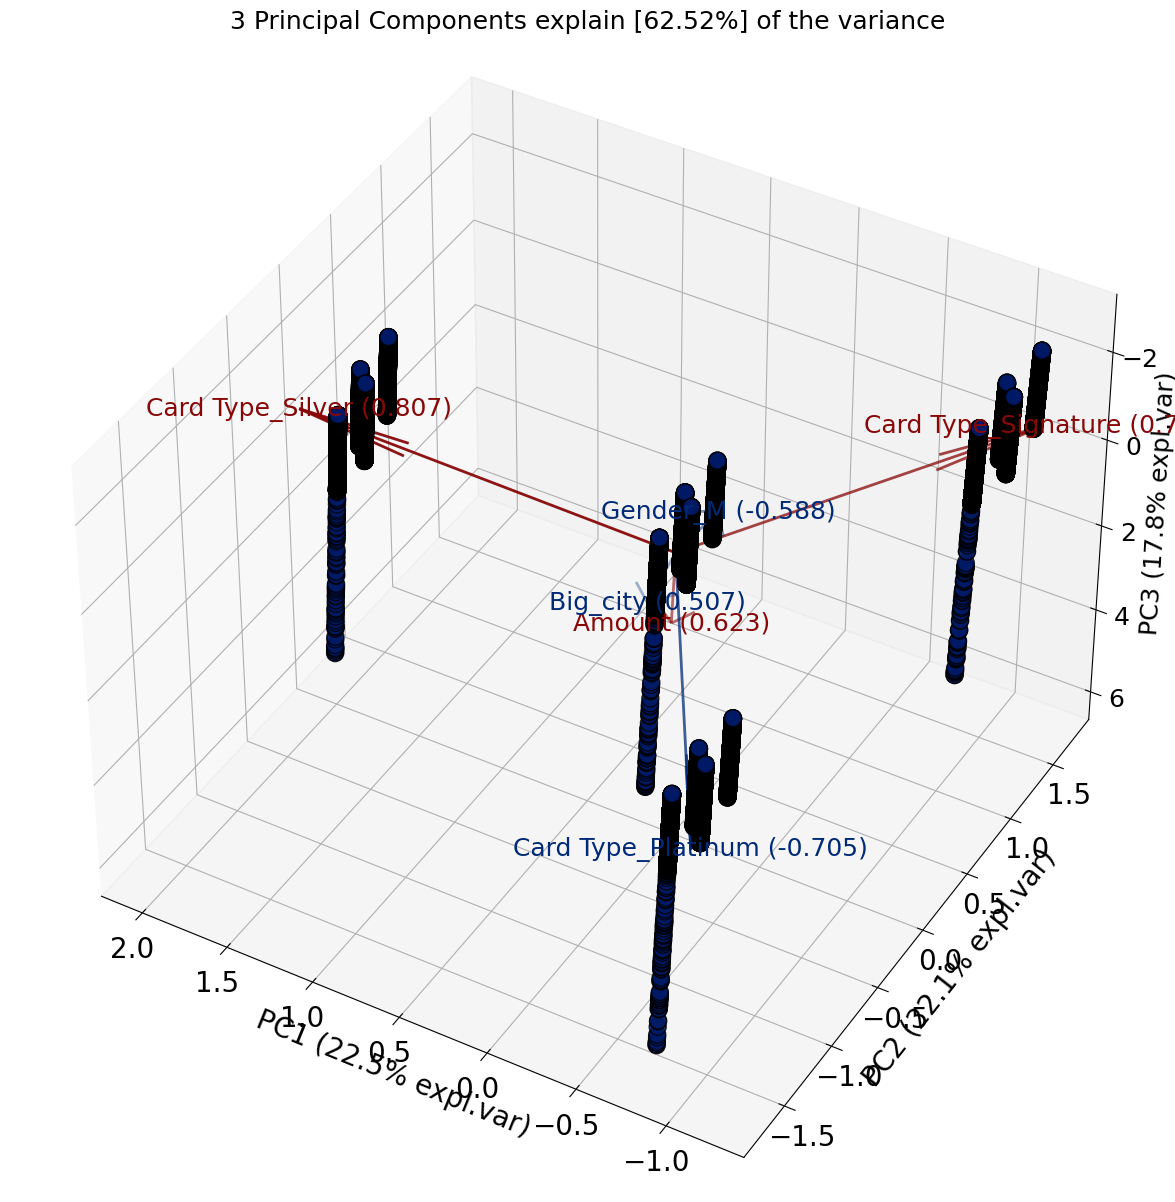

In [85]:
# Biplot
pcaModel.biplot(PC = [0, 1, 2])

### In this biplot we can see like 4 different groups, each one refering to the card type used.
### Each type card goes in a different direction, execpt for the one in the middle, that is due to all card types equals to 0, which we saw earlier that this is about the Gold Card Type
### Man tend to be on top of the PC 3. Women goes down in the PC3
### Amount of money goes down in the PC3 as it increases.
### They belong to a big city in the lower side of PC3 and as going up in this dimension it becomes big city.



# Step 9 - Plots, interpretations and conclussions

### Lets see it more accurately

In [69]:
# Creation of the dataset joining the PC1,PC2,PC3 of the PCA and the cluster labels we saved earlier
nuevo_conjunto = pcaModel.results['PC'].join(pd.DataFrame(cluster))

### Lets start plotting the groups of clusters

In [88]:

#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=0)
#fig.show()

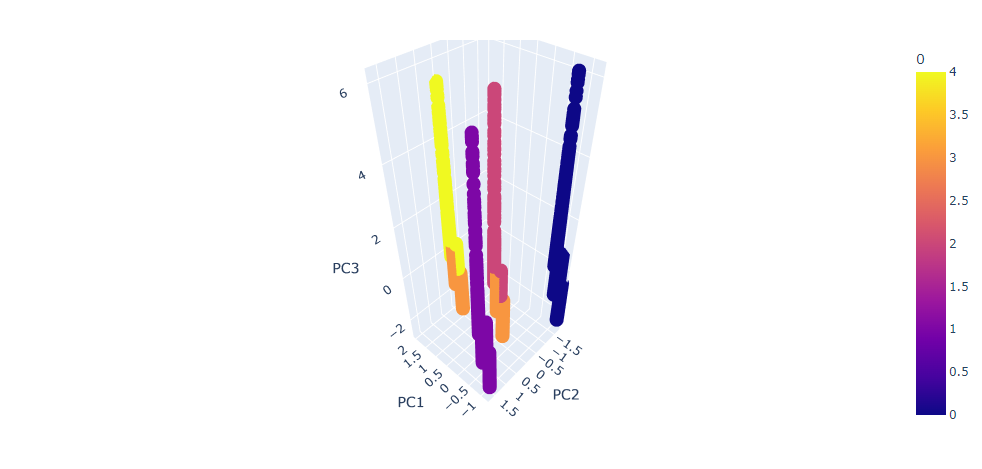

### This is so interesting, as saw in the biplot we can take the following conclussions:
#### Group 1 - Color blue - People using the Platinum Card, it doesnt matter the city, men or women, or amount spent
#### Group 2 - Color purple - People using the Signature Card, it doesnt matter the city, men or women, or amount spent
#### Group 3 - Color orange - Mainly men and some women, of small cities, spending lower amounts of money, using the Gold and Silver card
#### Group 4 - Color red - Mainly women, of big cities, spending higher amounts of money, using the Gold card
#### Group 5 - Color red - Mainly women, of big cities, spending higher amounts of money, using the Silver card

### This group clustering is valid and understandable, it caught my attention specially that this clustering captured the most important inisight of the EDA analysis, that was that women tend to buy more expensive things when they are in big cities.

### Lets finish plotting the variables to check if our conclussions were accurate

In [89]:

#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2["Card Type_Silver"])
#fig.show()

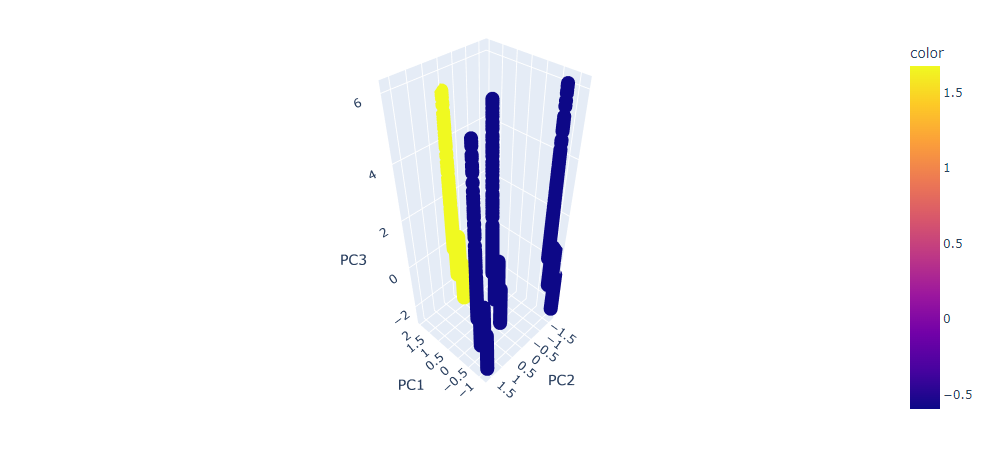

### The group on the left is the Silver card

In [90]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2["Card Type_Platinum"])
#fig.show()

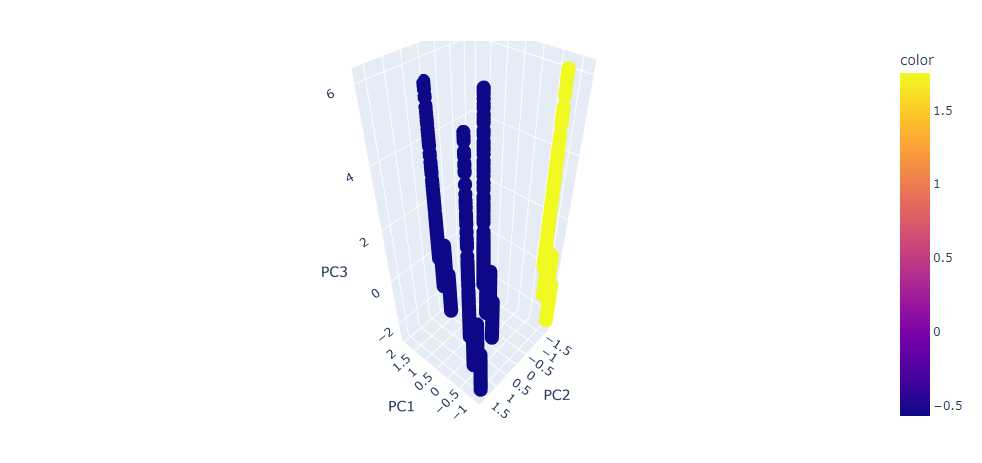

### The group on the right is the Platinum card

In [91]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2["Card Type_Signature"])
#fig.show()

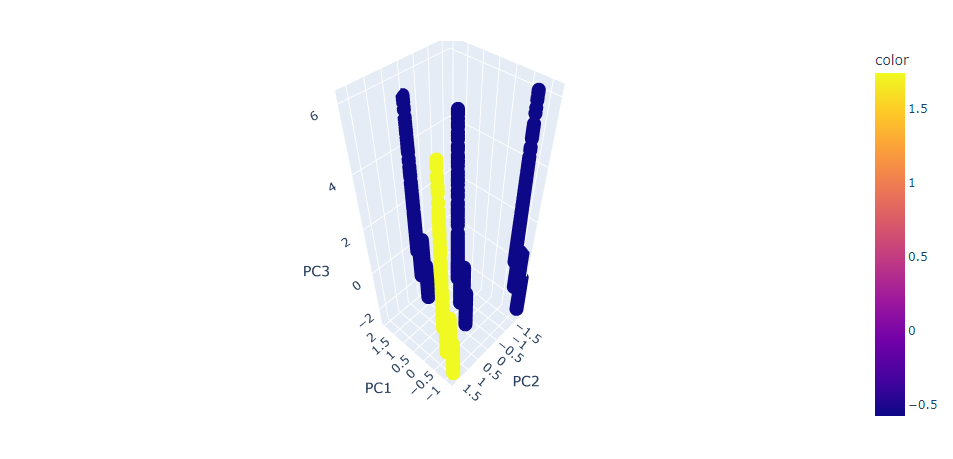

### The group on yellow are the Signature card

### The group in the middle that is not highlighted in any of the previous plots is the Gold card

In [92]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2.Gender_M)
#fig.show()

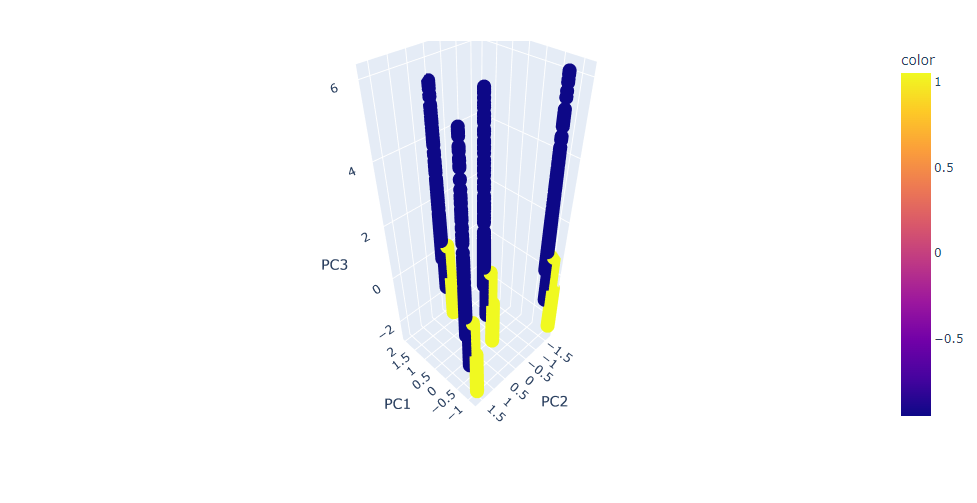

### Women on top and men in the lower side of the PC3, as expected

In [93]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2.Big_city)
#fig.show()

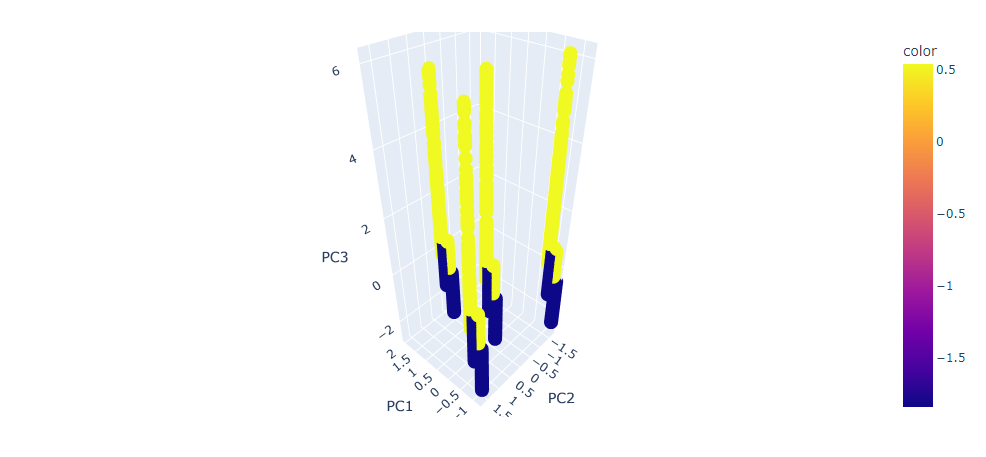

### Big cities on top, related more with women and small cities down, related more with men

In [94]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_dummy_scaled2.Amount)
#fig.show()

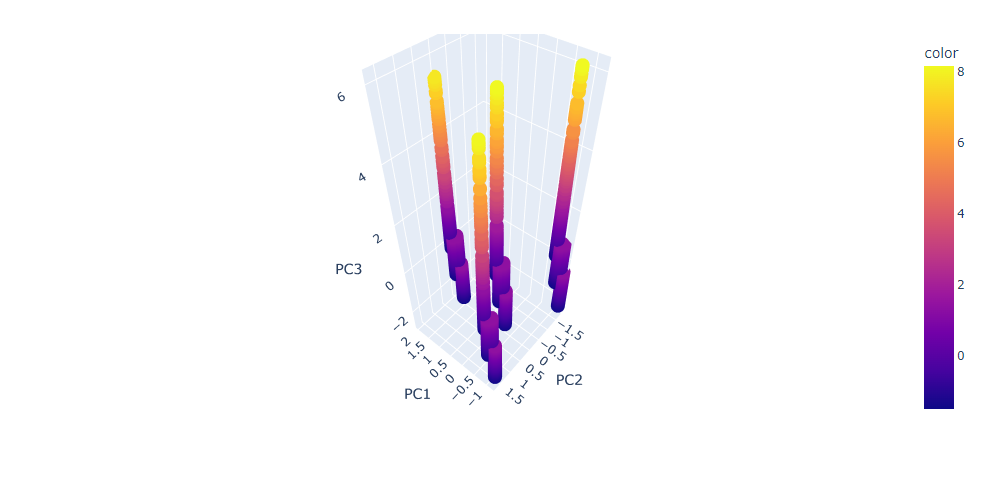

### Amount spent, lower amounts in the lower side of PC3 and increasing as it goes up, more related with women and big cities

# Conclussions:
### The plots showed our previous conclussions were right.
### I would suggest a higher inversion on marketing for women at bigger cities, as they are supossed to spend more money.